In [4]:
!pip install yfinance tensorflow pandas numpy scikit-learn matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
import os


In [5]:
import yfinance as yf

print("Fetching live data from Yahoo Finance")

ticker_input = input("Enter stock symbol or company name  ").strip().upper()
period = input("Enter data period : ").lower()
interval = input("Enter interval : ").lower()

aliases = {
    "TESLA": "TSLA",
    "APPLE": "AAPL",
    "MICROSOFT": "MSFT",
    "AMAZON": "AMZN",
    "GOOGLE": "GOOGL",
    "META": "META",
    "NVIDIA": "NVDA"
}

ticker = aliases.get(ticker_input, ticker_input)

try:
    data = yf.download(ticker, period=period, interval=interval, auto_adjust=True)
    if data.empty:
        raise ValueError(f"No data found for symbol '{ticker}'. Check if it's correct or available on Yahoo Finance.")
    data = data.reset_index()
    print(f"Fetched {len(data)} records for {ticker}")
    print(data.head())

except Exception as e:
    print(f" Error fetching data for {ticker}: {e}")



Fetching live data from Yahoo Finance
Enter stock symbol or company name  Reliance.ns
Enter data period : 1y
Enter interval : 1d


[*********************100%***********************]  1 of 1 completed

Fetched 249 records for RELIANCE.NS
Price        Date        Close         High          Low         Open  \
Ticker             RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS   
0      2024-10-31  1326.751099  1337.657490  1320.874545  1334.669425   
1      2024-11-01  1333.324829  1336.611629  1327.697281  1327.747130   
2      2024-11-04  1296.970093  1334.669502  1279.987869  1332.528030   
3      2024-11-05  1300.107544  1304.340637  1281.033699  1287.856425   
4      2024-11-06  1320.077759  1323.016097  1295.027781  1304.788845   

Price       Volume  
Ticker RELIANCE.NS  
0          9331650  
1          2127335  
2         19796890  
3         16267479  
4         21625209  


In [6]:
data = data.sort_values("Date").reset_index(drop=True)
close_prices = data["Close"].values.reshape(-1, 1)


split_idx = int(len(close_prices) * 0.8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(close_prices[:split_idx])
scaled_data = scaler.transform(close_prices)


seq_len = 60
X, y = [], []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))



split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [7]:
model_path = f"{ticker}_lstm_model.keras"

def build_lstm_model(input_shape, units=64, dropout=0.2, lr=0.001):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units, return_sequences=True),
        Dropout(dropout),
        LSTM(units, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
else:
    print("Training new model...")
    model = build_lstm_model((X_train.shape[1], 1))
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_split=0.1, verbose=1)
    model.save(model_path)
    print("💾 Model saved as", model_path)


Training new model...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.2535 - mae: 0.4351 - val_loss: 0.0599 - val_mae: 0.2372
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0560 - mae: 0.1891 - val_loss: 0.0668 - val_mae: 0.2515
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0429 - mae: 0.1655 - val_loss: 0.0080 - val_mae: 0.0698
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0314 - mae: 0.1371 - val_loss: 0.0108 - val_mae: 0.0838
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0246 - mae: 0.1285 - val_loss: 0.0063 - val_mae: 0.0716
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0221 - mae: 0.1202 - val_loss: 0.0085 - val_mae: 0.0786
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0226 - mae: 0.1232 - val_loss: 0.0041 - val_mae: 0.0510
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0182 - mae: 0.1075 - val_loss: 0.0042 - val_mae: 0.0512
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
📊 MSE: 590.9221, MAE: 19.0603


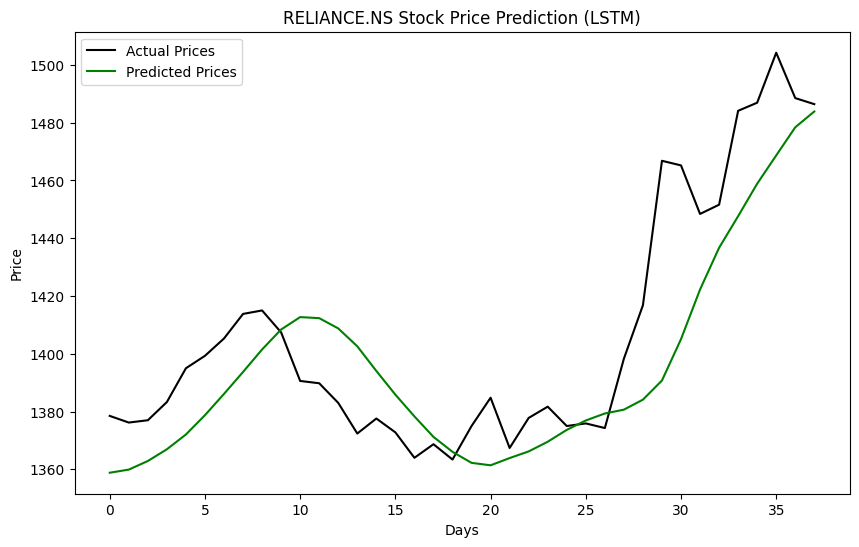

In [8]:
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print(f"📊 MSE: {mse:.4f}, MAE: {mae:.4f}")

plt.figure(figsize=(10,6))
plt.plot(actual, color='black', label='Actual Prices')
plt.plot(predicted, color='green', label='Predicted Prices')
plt.title(f"{ticker} Stock Price Prediction (LSTM)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [9]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

ticker_obj = yf.Ticker(ticker)
try:
    currency = ticker_obj.info.get("currency", "USD")
except:
    currency = "USD"

def predict_future_days(days_to_predict):
    """Predict next N days and estimate trend"""
    last_60 = scaled_data[-60:]
    predictions = []
    current_seq = last_60.copy()

    for _ in range(days_to_predict):
        pred = model.predict(current_seq.reshape(1, 60, 1), verbose=0)

        pred = 0.6 * pred + 0.4 * current_seq[-1]

        predictions.append(pred[0, 0])

        current_seq = np.append(current_seq[1:], pred)[-60:]

    predicted_scaled = np.array(predictions).reshape(-1, 1)
    predicted_prices = scaler.inverse_transform(predicted_scaled)

    return predicted_prices




n_days = int(input("Enter number of future days to predict: "))
future_preds = predict_future_days(n_days)

current_price = close_prices[-1][0]

print(f"\nCurrent {ticker} Price: {current_price:.2f} {currency}\n")

recent_mean = np.mean(close_prices[-5:])
future_mean = np.mean(future_preds)
change_pct = ((future_mean - recent_mean) / recent_mean) * 100

if change_pct > 0.5:
    trend = f"📈 STOCK LIKELY TO RISE (+{change_pct:.2f}%)"
elif change_pct < -0.5:
    trend = f"📉 STOCK LIKELY TO FALL ({change_pct:.2f}%)"
else:
    trend = f" STOCK LIKELY TO REMAIN STABLE ({change_pct:.2f}%)"


print(f"🔮 Predicted prices for next {n_days} days ({currency}):")
for i, price in enumerate(future_preds.flatten(), 1):
    print(f"Day {i}: {price:.2f} {currency}")

print(f"\n📊 Overall Trend: {trend}")




Enter number of future days to predict: 100

Current RELIANCE.NS Price: 1486.40 INR

🔮 Predicted prices for next 100 days (INR):
Day 1: 1485.64 INR
Day 2: 1484.03 INR
Day 3: 1480.57 INR
Day 4: 1475.34 INR
Day 5: 1468.75 INR
Day 6: 1461.32 INR
Day 7: 1453.65 INR
Day 8: 1446.02 INR
Day 9: 1438.67 INR
Day 10: 1431.82 INR
Day 11: 1425.62 INR
Day 12: 1420.18 INR
Day 13: 1415.57 INR
Day 14: 1411.81 INR
Day 15: 1408.87 INR
Day 16: 1406.72 INR
Day 17: 1405.28 INR
Day 18: 1404.48 INR
Day 19: 1404.21 INR
Day 20: 1404.37 INR
Day 21: 1404.87 INR
Day 22: 1405.60 INR
Day 23: 1406.46 INR
Day 24: 1407.37 INR
Day 25: 1408.26 INR
Day 26: 1409.06 INR
Day 27: 1409.71 INR
Day 28: 1410.19 INR
Day 29: 1410.45 INR
Day 30: 1410.50 INR
Day 31: 1410.33 INR
Day 32: 1409.94 INR
Day 33: 1409.36 INR
Day 34: 1408.60 INR
Day 35: 1407.70 INR
Day 36: 1406.69 INR
Day 37: 1405.59 INR
Day 38: 1404.45 INR
Day 39: 1403.28 INR
Day 40: 1402.13 INR
Day 41: 1401.01 INR
Day 42: 1399.95 INR
Day 43: 1398.95 INR
Day 44: 1398.04 INR


In [10]:
specific_day = int(input(f"\nEnter which day’s prediction to view (1-{n_days}): "))

if 1 <= specific_day <= n_days:
    specific_price = future_preds[specific_day - 1][0]
    today_price = close_prices[-1][0]
    day_change = ((specific_price - today_price) / today_price) * 100

    if day_change > 0.5:
        day_trend = f"📈 UP (+{day_change:.2f}%)"
    elif day_change < -0.5:
        day_trend = f"📉 DOWN ({day_change:.2f}%)"
    else:
        day_trend = f" STABLE ({day_change:.2f}%)"

    print(f"\nPrediction for Day {specific_day}: {specific_price:.2f} {currency}")
    print(f"Day {specific_day} Trend vs Today: {day_trend}")
else:
    print("Invalid day number.")



Enter which day’s prediction to view (1-100): 4

Prediction for Day 4: 1475.34 INR
Day 4 Trend vs Today: 📉 DOWN (-0.74%)


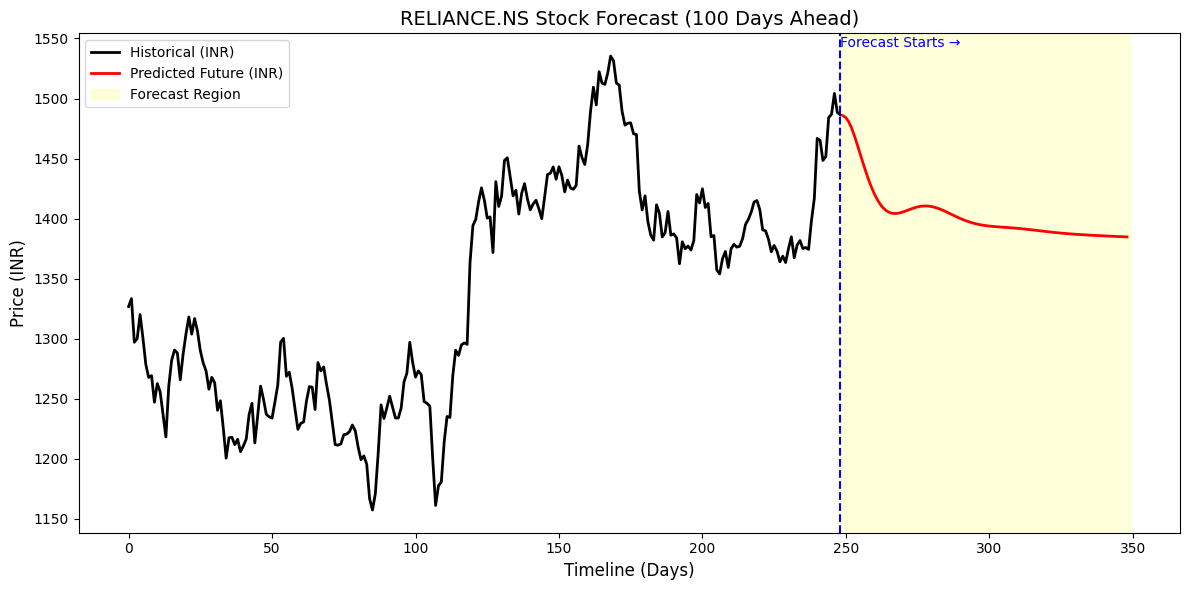

In [11]:
plt.figure(figsize=(12,6))

plt.plot(range(len(close_prices)), close_prices,
         color='black', linewidth=2, label=f'Historical ({currency})')

plt.plot(range(len(close_prices), len(close_prices) + n_days), future_preds,
         color='green' if change_pct > 0 else 'red', linewidth=2,
         label=f'Predicted Future ({currency})')

plt.axvline(x=len(close_prices)-1, color='blue', linestyle='--', linewidth=1.5)
plt.text(len(close_prices)-1, max(close_prices)*1.005,
         'Forecast Starts →', color='blue', fontsize=10)

plt.axvspan(len(close_prices)-1, len(close_prices) + n_days,
            color='yellow', alpha=0.15, label='Forecast Region')

plt.title(f"{ticker} Stock Forecast ({n_days} Days Ahead)", fontsize=14)
plt.xlabel("Timeline (Days)", fontsize=12)
plt.ylabel(f"Price ({currency})", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()


commented

In [ ]:
'''
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

ticker_obj = yf.Ticker(ticker)
try:
    currency = ticker_obj.info.get("currency", "USD")
except:
    currency = "USD"

def predict_future_days(days_to_predict):
    """Predict next N days and estimate trend"""
    last_60 = scaled_data[-60:]
    predictions = []
    current_seq = last_60.copy()

    for _ in range(days_to_predict):
        pred = model.predict(current_seq.reshape(1, 60, 1), verbose=0)
        # Blend predicted value with last observed to prevent drift
        pred = 0.6 * pred + 0.4 * current_seq[-1]
        predictions.append(pred[0, 0])
        current_seq = np.append(current_seq[1:], pred)[-60:]

    predicted_scaled = np.array(predictions).reshape(-1, 1)
    predicted_prices = scaler.inverse_transform(predicted_scaled)
    return predicted_prices


n_days = int(input("Enter number of future days to predict: "))
future_preds = predict_future_days(n_days)

recent_mean = np.mean(close_prices[-5:])
future_mean = np.mean(future_preds)
change_pct = ((future_mean - recent_mean) / recent_mean) * 100

if change_pct > 0.5:
    trend = f"📈 STOCK LIKELY TO RISE (+{change_pct:.2f}%)"
elif change_pct < -0.5:
    trend = f"📉 STOCK LIKELY TO FALL ({change_pct:.2f}%)"
else:
    trend = f"⚖️ STOCK LIKELY TO REMAIN STABLE ({change_pct:.2f}%)"

print(f"\nPredicted prices for next {n_days} days ({currency}):")
for i, price in enumerate(future_preds.flatten(), 1):
    print(f"Day {i}: {price:.2f} {currency}")

print(f"\nOverall Trend: {trend}")
'''


In [12]:

'''
plt.figure(figsize=(10,6))
plt.plot(range(len(close_prices)), close_prices, color='black', label=f'Historical ({currency})')
plt.plot(range(len(close_prices), len(close_prices)+n_days), future_preds,
         color='green' if change_pct>0 else 'red', label=f'Predicted Future ({currency})')
plt.title(f"{ticker} Stock Forecast ({n_days} days)")
plt.xlabel("Days")
plt.ylabel(f"Price ({currency})")
plt.legend()
plt.show()
'''
